## Kaggle 2019 Data Science Bowl

This notebook contains my submissions to the 2019 Kaggle Data Science Bowl, a supervised learning competition. The data comes from the PBS KIDS Measure Up! app, a game-based learning tool developed as a part of the CPB-PBS Ready To Learn Initiative with funding from the U.S. Department of Education. Competitors were challenged to predict scores on in-game assessments and create an algorithm that will lead to better-designed games and improved learning outcomes.

The work is organized as follows:

1. Data Load and Inspection
2. EDA
3. Ground Truth
4. Feature engineering 
5. Feature transformations
5. Pre-processing 
6. Evaluation: Quadratic Weighted Kappa (qwk)
7. Models
    - KNN Model
    - SVM Model
    - Decision Tree Model(single)
    - Gradient Boosted Tree Model
8. Discussion and Takeaways

## 1. Data Loading and Inspection

In [3]:
# imports
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import datetime
from tqdm.auto import tqdm
from collections import Counter
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
# %load_ext line_profiler

In [18]:
basepath = '../../../../dsb_data/'
train = pd.read_csv(basepath + 'processed/train.csv/train.csv') #df.head()

In [16]:
test = pd.read_csv(basepath + 'processed/test.csv/test.csv') #df.head()

In [4]:
print('Training.csv file has {} rows and {} columns'.format(train.shape[0], train.shape[1]))

Training.csv file has 11341042 rows and 11 columns


In [5]:
print('Test.csv file has {} rows and {} columns'.format(test.shape[0], test.shape[1]))

Test.csv file has 1156414 rows and 11 columns


In [21]:
specs = pd.read_csv('../references/specs.csv')
print('specs.csv file has {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

specs.csv file has 386 rows and 3 columns


In [22]:
train_labels = pd.read_csv('../references/train_labels.csv/train_labels.csv')
print('train_lablels.csv file has {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))
#train_labels

train_lablels.csv file has 17690 rows and 7 columns


In [23]:
sample = pd.read_csv('../references/sample_submission.csv')
print('sample submission file has {} rows and {} columns'.format(sample.shape[0], sample.shape[1]))

sample submission file has 1000 rows and 2 columns


## 2. EDA

Each installation_id is roughly equivalent to a user. let's see how many installation_ids there are

In [26]:
users = train.installation_id.unique()
len(users) # number of distinct users

17000

There are 17000 unique installation_id's in the training set. Let's examine the breakdown of event types for a sample: `installation_id =='0001e90f'` (from the first row in the dataset)

In [24]:
types = train.loc[train['installation_id']=='0001e90f'].groupby(['type'],as_index=False).size().reset_index(name='counts')
types

,type,counts
0,Activity,469
1,Clip,5
2,Game,883


Below i calculate the total time spent on each different types of events in minutes for each installation_id. 

In [40]:
N=500    # how many users to aggregate over in train set
user_times = np.zeros(N)
times_per_type = [0,0,0,0]
for j in tqdm(range(N)):
    user = users[j]
    event_types = [0,0,0,0]
    sessions_typed = [0,0,0,0]
    user_dat = train.loc[(train['installation_id']==user)]
    event_types[0] = user_dat.loc[user_dat['type'] == 'Activity']
    sessions_typed[0] = event_types[0]['game_session'].unique()
    event_types[1] = user_dat.loc[user_dat['type'] == 'Clip']
    sessions_typed[1] = event_types[1]['game_session'].unique()
    event_types[2] = user_dat.loc[user_dat['type'] == 'Game']
    sessions_typed[2] = event_types[2]['game_session'].unique()
    event_types[3]   = user_dat.loc[user_dat['type'] == 'Assessment']
    sessions_typed[3] = event_types[3]['game_session'].unique()
        
    for i in range(4):
        type_time = 0.0
        for session in sessions_typed[i]:
            
            #there may be an issue where there are NO events and then it doesn't figure this out??
            sesh_start_ts = event_types[i].loc[event_types[i]['game_session']==session]['timestamp'].min()
            sesh_start_dt = datetime.datetime.strptime(sesh_start_ts,'%Y-%m-%dT%H:%M:%S.%fZ')
            sesh_end_ts = event_types[i].loc[event_types[i]['game_session']==session]['timestamp'].max()
            sesh_end_dt = datetime.datetime.strptime(sesh_end_ts,'%Y-%m-%dT%H:%M:%S.%fZ')

            type_time = type_time + (sesh_end_dt - sesh_start_dt).total_seconds()/60.0
            times_per_type[i]+=type_time
        
    total_time = sum(times_per_type)
    user_times[j] = total_time

Below I plot the times in terms of the playing category -- we can see that kids spent most of the time playing games or activities and a little bit of time on assessments. Clip seems unimportant.

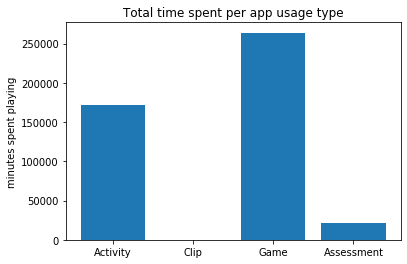

In [48]:
p2 = plt.bar([1,2,3,4], times_per_type);

plt.title('Total time spent per app usage type');
plt.ylabel('minutes spent playing')
plt.xticks([1,2,3,4], ('Activity', 'Clip', 'Game', 'Assessment'));

## 3. Ground truth

Note that the Bird Measurer assessment has two parts however we consider the it to be passed correctly if just the first part is passed, that is the 4110 code. Here, I duplicate the train_labels that were provided by parsing the train data set and calculating the accuracy. 

In [53]:
assessments = train.loc[(train['type'] == 'Assessment') & (((train['event_code'] == 4100)&(train['title'] != 'Bird Measurer (Assessment)')) | (train['event_code'] == 4110))].copy()
assessments['num_correct'] = True

test_assessments = test.loc[(test['type'] == 'Assessment') & (((test['event_code'] == 4100)&(test['title'] != 'Bird Measurer (Assessment)')) | (test['event_code'] == 4110))].copy()
test_assessments_for_union = test_assessments.copy()

test_assessments['num_correct'] = True    # initialize all assessments as succeeding

assessments.loc[assessments['event_data'].str.contains(":false,"),'num_correct'] = False   # update labels where user incorrect

test_assessments.loc[test_assessments['event_data'].str.contains(":false,"),'num_correct'] = False  # ditto on test set

assessments['num_incorrect'] = np.where(assessments.num_correct > 0,0,1)   # label incorrect

test_assessments['num_incorrect'] = np.where(test_assessments.num_correct > 0,0,1)

The way I calculate the number of incorrect assessments is using a groupby(). We need to know both number incorrect as well as if there was a correct answer in separate columns. I chose two separately create these two columns and then merge them using an inner join, however this is probably not best practice, there is probably a way to create two aggregate columns in a single step without creating two dataframes (stackoverflow this) perhaps using the agg() function  for multiple aggregations - that might do the trick

In [55]:
g = assessments.groupby(['game_session','installation_id','title'],as_index=False)['num_correct'].sum().sort_values(by=['installation_id'])
h = assessments.groupby(['game_session','installation_id','title'],as_index=False)['num_incorrect'].sum().sort_values(by=['installation_id'])

ggg = test_assessments.groupby(['game_session','installation_id','title'],as_index=False)['num_correct'].sum().sort_values(by=['installation_id'])
hhh = test_assessments.groupby(['game_session','installation_id','title'],as_index=False)['num_incorrect'].sum().sort_values(by=['installation_id'])

g['num_correct'] = g['num_correct'].astype(int)      #g.shape
h['num_incorrect'] = h['num_incorrect'].astype(int)   #h.shape

ggg['num_correct'] = ggg['num_correct'].astype(int)      #g.shape
hhh['num_incorrect'] = hhh['num_incorrect'].astype(int)   #h.shape

merged_inner = pd.merge(left=g,right=h, left_on='game_session', right_on='game_session')

test_merged_inner = pd.merge(left=ggg,right=hhh, left_on='game_session', right_on='game_session')

df1 = merged_inner[['game_session','installation_id_x','title_x','num_correct','num_incorrect']]
df2 = test_merged_inner[['game_session','installation_id_x','title_x','num_correct','num_incorrect']] 
pd.options.mode.chained_assignment = None
df1.rename(columns = {'installation_id_x':'installation_id'}, inplace = True)
df1.rename(columns = {'title_x':'title'}, inplace = True)
df2.rename(columns = {'installation_id_x':'installation_id'}, inplace = True)
df2.rename(columns = {'title_x':'title'}, inplace = True)

df1['accuracy'] = df1.apply(lambda row: row.num_correct/(row.num_correct + row.num_incorrect), axis=1)
df2['accuracy'] = df2.apply(lambda row: row.num_correct/(row.num_correct + row.num_incorrect), axis=1)

In [57]:
# define accuracy groups

def groupacc(row):
    if row['num_correct'] == 1 and row['num_incorrect'] == 0:
        return 3
    if row['num_correct'] == 1 and row['num_incorrect'] == 1:
        return 2
    if row['num_correct'] == 1 and row['num_incorrect'] > 1:
        return 1
    if row['num_correct'] == 0: 
        return 0
    return 'Other'

df1['accuracy_group'] = df1.apply(groupacc, axis=1)
df2['accuracy_group'] = df2.apply(groupacc, axis=1)

# I did a check comparing my results to the provided train_labels

c = df1.sort_values(by=['game_session'])
k = train_labels.sort_values(by=['game_session'])

comparison_array = c.values == k.values

if False in comparison_array:
    print ("Not the same")
    
len(np.where(comparison_array==False)[0])  # 46 differences due to floating point stuff

Not the same


46

## 4. Feature engineering

The target, e.g. `y`, is the accuracy group for an assessment session, e.g. this is what you are trying to predict.
The features, `X` are collected by looking up the user's historical data for each assessment session, you only want to consider data up to the current timestamp of the assessment you are training or predicting on (except for the type of assessment). Though it would be possible to incorporate historical data from test set into train, this would leak data from test into the model and also might hurt the build process mixing things up too much since the private test set is still withheld. It's a thought though, but probably wrong.


Let's pair down the train set to only the ids that actually took (e.g. started 2000) an assessment and also made an attempt (4100/4110) and do some more inspection, with comments detailing below. One issue is features which have NA for some data - (accumulated previous accuracy group) -> our approach will be to substitue the mean value for the type. Using 0 is another way which may produce better results. Below I start by doing some encodings.  We need to predict the score for the last assessment in the test set. Also, despite some unclear language in the instructions, after some effort it became clear to me from inspection that **the last assessment (by timestamp) has been truncated for each user in the test set**. Some of the test set users have no previous assessments to learn from. 


In [59]:
# Encode the assessment title

list_of_assessment_titles = list(set(assessments['title'].unique()))
list_of_assessment_titles.sort()

assessment_titles_map = dict(zip(list_of_assessment_titles, np.arange(len(list_of_assessment_titles))))
assessment_titles_map

assessments['title'] = assessments['title'].map(assessment_titles_map)    # note if you run this twice it will break
train_labels['title'] = train_labels['title'].map(assessment_titles_map)  # note if you run this twice it will break

print(len(assessments['game_session'].unique()))  # unique sessions of type assesment in train set
train_reduced_users = assessments['installation_id'].unique()
print(len(train_reduced_users))  # unique users who made at least one attempt on an assessment in train

train = train.loc[train['installation_id'].isin(train_reduced_users)]  # drop some data where user has no assessment
#train.shape

test_users = test.installation_id.unique()    # installation_ids in test set
print(len(test_users))
len(set(test_users).intersection(set(users)))  # there is no intersection in installation_ids between train and test

# Combine the historical test portion with the predict set: which is the last assessment (no 4100/4110 code)

test_predict = test.loc[test['type'] == 'Assessment'].groupby('installation_id',as_index=False).last()

# you need to combine test_assessments so that it has those last rows basically do a union/concat at this stage

test_final_assessments = pd.concat([test_assessments_for_union,test_predict],sort=False)
test_final_assessments = test_final_assessments.sort_values(by=['installation_id','timestamp'])

# calculate mean group accuracies on train

mean_group_accs = train_labels.groupby('title',as_index=False).mean()['accuracy_group']
list(mean_group_accs)

17690
3614
1000


[1.3237436270939549,
 2.3004095398699107,
 2.306781750924784,
 0.8383092921838309,
 2.2142667021559754]

In [61]:
# the function to build train or test features. I don't think this code is efficient. In future consider using python
# Counter() function as a good resource. Also do some unncessary extra work looping through entire time history for each user 
# instead of working incrementally would definitely be more efficient

def build_features(num,test_or_train):

    N=num   # number of users to build data for, to go to production set N = len(train/test_users)
    features = []   # this will by the full data for each assessment   X  & Y
    build_test = test_or_train   # False

    for j in tqdm(range(N)):

        if build_test == False:
            user = train_reduced_users[j]   
            prev_hist = train.loc[train['installation_id']==user]   # for previous history counts, narrowed to user    
            user_assessments = assessments.loc[assessments['installation_id']==user]  # for previous cum_accuracy_grps    
            user_sessions = user_assessments['game_session'].unique()  # time ordered
        else:
            user = test_users[j]
            prev_hist = test.loc[test['installation_id']==user]   # for previous history counts, narrowed to user 
            user_sessions = test_final_assessments.loc[test_final_assessments['installation_id']==user]['game_session'].unique()

        counters = np.array([0.0,0.0,0.0,0.0,0.0])  # number of each type of assessment initialization
        cumalitive_acc_groups = np.array(list(mean_group_accs))   # initialization
        #cumalitive_acc_groups = np.array([0.0,0.0,0.0,0.0,0.0])   # alternative zero initialization

        magmapeak_counts = 0
        treetopcity_counts = 0
        crystalcaves_counts = 0

        game_counts = 0
        clip_counts = 0
        activity_counts = 0
        assess_counts = 0

        ii = 1

        for session in user_sessions:     # these are already time-ordered 

            # code to convert timestamp data to datetime data
            prev_hist['timestamp'] = pd.to_datetime(prev_hist['timestamp'])  # get the time at the start of the game_session
            the_time = prev_hist.loc[prev_hist['game_session']==session]['timestamp'].iloc[0]
            the_past = prev_hist.loc[prev_hist['timestamp'] < the_time]  # this could be empty!! 
            num_events = the_past.groupby('world',as_index=False).size().reset_index(name='counts')
            num_sessions_by_type = the_past.groupby('game_session',as_index=False).last().groupby('type').size().reset_index(name='tcounts')

            for index, row in num_sessions_by_type.iterrows():
                if row['type'] == 'Game':
                    game_counts = row['tcounts']
                if row['type'] == 'Activity':
                    activity_counts = row['tcounts']
                if row['type'] == 'Assessment':
                    assess_counts = row['tcounts'] 
                if row['type'] == 'Clip':
                    clip_counts = row['tcounts']

            # now you want to count number of previous events for this user before this timestamp

            user_features = []

            user_features.append(clip_counts)
            user_features.append(activity_counts)
            user_features.append(assess_counts)
            user_features.append(game_counts)  

            if build_test == False:
                sesh_dat = train_labels.loc[train_labels['game_session'] == session]
                score = sesh_dat['accuracy_group'].iloc[0]
            else:
                if ii < len(user_sessions):
                    sesh_dat = df2.loc[df2['game_session'] == session]
                    score = sesh_dat['accuracy_group'].iloc[0]
                else:
                    score = 0         

            title = prev_hist.loc[prev_hist['game_session']==session]['title'].iloc[0]   
            title = assessment_titles_map[title]
            
            #user_features.append(user)
            user_features.append(title)

            total_accum = np.sum(cumalitive_acc_groups)/(np.sum(counters)+5.0)
            user_features.append(cumalitive_acc_groups[0]/(counters[0]+1.0))
            user_features.append(cumalitive_acc_groups[1]/(counters[1]+1.0))
            user_features.append(cumalitive_acc_groups[2]/(counters[2]+1.0))
            user_features.append(cumalitive_acc_groups[3]/(counters[3]+1.0))
            user_features.append(cumalitive_acc_groups[4]/(counters[4]+1.0))

            if title == 0:
                counters[0] += 1
                cumalitive_acc_groups[0] = cumalitive_acc_groups[0] + score
            elif title == 1:
                counters[1] += 1
                cumalitive_acc_groups[1] = cumalitive_acc_groups[1] + score
            elif title == 2:
                counters[2] += 1
                cumalitive_acc_groups[2] = cumalitive_acc_groups[2] + score
            elif title == 3:
                counters[3] += 1
                cumalitive_acc_groups[3] = cumalitive_acc_groups[3] + score
            elif title == 4:
                counters[4] += 1
                cumalitive_acc_groups[4] = cumalitive_acc_groups[4] + score

            user_features.append(total_accum)

            user_features.append(score)

            for index, row in num_events.iterrows():
                if row['world'] == 'MAGMAPEAK':
                    magmapeak_counts = row['counts']
                if row['world'] == 'TREETOPCITY':
                    treetopcity_counts = row['counts']
                if row['world'] == 'CRYSTALCAVES':
                    crystalcaves_counts = row['counts']  

            user_features.append(magmapeak_counts)
            user_features.append(treetopcity_counts)
            user_features.append(crystalcaves_counts)
            user_features.append(sum(num_events['counts']) - (magmapeak_counts + treetopcity_counts+crystalcaves_counts))
            user_features.append(sum(num_events['counts']))
            
            if build_test == False:
                features.append(user_features)
            else:
                if ii == len(user_sessions):
                    features.append(user_features)
            ii += 1
            
    return features

Now it's time to build the train and test set. Alternatively, if we already built the train we can simply load it from csv

In [74]:
test = pd.DataFrame(build_features(len(test_users),True))
test = test.round(2)

#train = pd.DataFrame(build_features(len(train_reduced_users),False))
#train = train.round(2)

#train.to_csv('train.csv', index=False)

# to read in features that are already built uncomment belwo
#train = pd.read_csv('train.csv')


Alot more features could be included such as some **durations**... alot more could be done here but for now we just want to go ahead and get it to work and then we can come back to feature engineering later if we have time


## 5. Feature transformations

I did not do any feature or target transformations. One idea for example is to log transform numerical data. You should consider this in later work.

## 6. Pre-processing

In [80]:
# preprocessing 

y_train = train['11']
y_test = test[11]
X_train = train.drop('11', axis=1)
X_test = test.drop(11, axis=1)

categorical = 4         # categoricals
#categorical = '4'   #  if you load train it reads header as string (alternatively cast header to int)

# or do this for some models

X_train['4'] = X_train['4'].astype('category') 

X_test[4]= X_test[4].astype('category') 

# dummy variable encoding (not always desired)

dumb = pd.get_dummies(X_train['4'],drop_first=True,prefix='g')
dumby = pd.get_dummies(X_test[categorical],drop_first=True,prefix='j')

X_train = X_train.drop(['4'],axis=1)
X_test = X_test.drop([categorical],axis=1)

X_train = pd.concat([X_train,dumb],axis=1)
X_test = pd.concat([X_test,dumby],axis=1)


# Feature scaling - if desired for model

X_scaled = preprocessing.scale(X_train)

X_test_scaled = preprocessing.scale(X_test)


## 7. Evaluation metric -  quadratic weighted kappa (qwk)

This is a metric commonly used for measuring the aggreement between two raters where bigger differences are penalized (the squared). The outer product is simply coming from the assuming independent marginals on true and predicted sets (from histograms) and then computing the independent joint probability by multiplying.

In [67]:
def qwk(a1,a2):
    N = 4
    o = confusion_matrix(a1,a2)
    w = np.zeros(shape=(N,N))
    for i in range(N):
        for j in range(N):
            w[i,j] = (i-j)**2
    w = w/((N-1)*(N-1)) 
    w = w.round(3)
    
    e = np.outer(np.histogram(a1, [i for i in range(N+1)])[0],np.histogram(a2,[i for i in range(N+1)])[0])

    e = e/np.sum(e)
    o = o/np.sum(o)

    return 1 - np.sum(np.multiply(o,w))/np.sum(np.multiply(e,w))



## 8. Models


Our approach to modelling is to work from simple models to complex models and to learn about how to implement each model correctly while building cross-validation into the pipeline as well. The idea for this competition is to learn how to build models, not neccessarily to win this competition... though that would be nice... I was able to successfully run the following models

1. KNN

2. Support Vector Machine

3. Single decision tree 

4. Gradient boosted tree ensemble - regression with thresholding


Models that I did not get time to try but which would be good

1. Neural Networks

2. Ridge/Logistic/Lasso regressions with/without thresholding

3. Multi-Layer Perceptrons

Different models handle categorical and numerical data differently in terms of feature transformations and scaling/preprocessing, this should be kept in mind.



### K nearest neighbors

Below we do cross-validation to see what value of k (the hyperparameter) optimizes. Smaller values of k lead to overfitting.
KNN is the dumbest of models but provides a starting point.

In [83]:
mean_scores = []
nns = []
stds = []
qwks_mean = []
for nn in tqdm(range(2,30,5)):
    
    cv = KFold(n_splits=5)
    neigh = KNeighborsClassifier(n_neighbors = nn)
    
    scores = []
    qwks = []

    # if you are dealing with dataframes, you have to index with X.iloc[test_index] etc. !!1
    for train_index, test_index in cv.split(X_scaled,y_train):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        neigh.fit(X_train_cv, y_train_cv)
        scores.append(neigh.score(X_test_cv, y_test_cv))
        y_pred = neigh.predict(X_test_cv)
        qwk_res = qwk(y_pred,y_test_cv)
        qwks.append(qwk_res)
    qwks_mean.append(np.mean(qwks))
    scores
    nns.append(nn)
    stds.append(np.std(scores))
    mean_scores.append(np.mean(scores))

In [ ]:
plt.plot(nns,mean_scores);
plt.xlabel("k");plt.ylabel("cv-mean-accuracy");
fig1, ax1 = plt.subplots();
ax1.plot(nns,qwks_mean);
plt.xlabel('k');
plt.ylabel('qwk_mean');

# final submit chose k = 20
neigh = KNeighborsClassifier(n_neighbors = 20)
neigh.fit(X_scaled, y_train)
y_pred = neigh.predict(X_test_scaled)

This model yielded a score of **0.425** on the private test set

### Support Vector Machine

We repeat the cross-validation strategy over the hyperparameter C for support vector machine. We also require the data to be standardized for this model

In [ ]:
mean_scores = []
nns = []
stds = []
qwks_mean = []
Cs = [0.1,0.25,0.5,0.75,1.0]

for c in tqdm(range(5)):
    
    cv = KFold(n_splits=5)
    clf = SVC(C=Cs[c],gamma='auto')

    scores = []
    qwks = []
    # if you are dealing with dataframes, you have to index with X.iloc[test_index] etc. !!1
    for train_index, test_index in cv.split(X_scaled,y_train):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        clf.fit(X_train_cv, y_train_cv)
        
        scores.append(clf.score(X_test_cv, y_test_cv))
        
        y_pred = clf.predict(X_test_cv)
        qwk_res = qwk(y_pred,y_test_cv)
        qwks.append(qwk_res)
        
    qwks_mean.append(np.mean(qwks))
    stds.append(np.std(scores))
    mean_scores.append(np.mean(scores))

In [ ]:
plt.plot(Cs,mean_scores);
plt.xlabel("k");plt.ylabel("cv-mean-accuracy");
fig1, ax1 = plt.subplots();
ax1.plot(Cs,qwks_mean);
plt.xlabel('k');
plt.ylabel('qwk_mean');

# final submit chose C = 0.75
clf = SVC(C = 0.75)
clf.fit(X_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

This model yielded a score of **0.43** on the private test set

### Tree Classifier

Here we try a simple single decision tree

In [ ]:
mean_scores = []
stds = []
qwks_mean = []

depths = [2,4,6,8,10,12,14,16,18,20]

for depth in depths:
    
    cv = KFold(n_splits=10)
    clf = DecisionTreeClassifier(random_state=0,max_depth=depth)

    scores = []
    qwks = []

    # if you are dealing with dataframes, you have to index with X.iloc[test_index] etc. !!1
    for train_index, test_index in cv.split(X_train,y_train):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        clf.fit(X_train_cv, y_train_cv)
        
        scores.append(clf.score(X_test_cv, y_test_cv))
        y_pred = clf.predict(X_test_cv)                
        qwk_res = qwk(y_pred,y_test_cv)                 
        qwks.append(qwk_res)
        
    qwks_mean.append(np.mean(qwks))
    stds.append(np.std(scores))
    mean_scores.append(np.mean(scores))'''

In [ ]:
plt.plot(depths,mean_scores);
plt.xlabel("depth");plt.ylabel("cv-mean-accuracy");
fig1, ax1 = plt.subplots();
ax1.plot(depths,qwks_mean);
plt.xlabel("depth")
plt.ylabel("qwk")

# final submit chose max_depth = 7
clf = DecisionTreeClassifier(random_state=0,max_depth=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)   # do you want feature scaling?

#submission = {'installation_id': test_users, 'accuracy_group': y_pred}
#sample_submission = pd.DataFrame(d)
#sample_submission.to_csv('submission.csv', index=False)


## 10. Discussion and Takeaways

There's quite a few things I could have done better (or could have just done at all).

1. I found that the lack of design of the build process for train and test sets led to problems later. In general both design and efficient coding are paramount. The problem was that there were some differences in the build pipeline for test set compared to train. This has to do with the rules of the kaggle competition and how it was structured. Avoid the thematic **error** of not designing the train and test feature building process - do your homework to make this integrated and scalable!!


2. You can actually average the results from multiple models, and then threshold, quote below is from teh 8th place finisher

"Simple average 18 of predictions of 9 models (2 outputs, acc and acc_group per model). then use threshold Optimizer to find thresholds. I randomly initiallized the thresholds for threshold Optimizer around training target distribution, and ran threshold Optimizer 25 times, then chose the one with best cv qwk.
I did a 5 fold simulation(4 folds act as oof we have, 1 fold acts as label of test data) to compare several ways of deciding thresholds. Found that using threshold Optimizer is better than deciding thresholds by simple using training target distributiion."

3. You can use NN or perceptron models!!

4. Feature transformations - log transforms of numeric data

5. Feature interactions

Another thing I didn't do very well was simply organizing my code. It's very important to separate each step and to block your code into separate compartments **of appropriate length, you simply had too small juypyter cells, too many distinct cell code blocks unnesseccarily for a scattered effect** having too long blocks, would also be bad ('spaghetti code')

Another problem I noticed while reviewing my code, is that I named some variables like `gggg` or `hh` instead of giving descriptive names. If you find yourself having to do this, then maybe you are creating temporary variable unneccesarily and can improve the design with nested, more efficient codes. Otherwise, avoid the thematic **error** of using non-descriptive names!!

another thing: avoid thematic **error** of not deleting/dropping unneeded objects to free up memory